# Importe das bibliotecas utilizadas

In [ ]:
#Importando a biblioteca
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import  confusion_matrix

import matplotlib.pyplot as plt

# Importando o dataset (Os dados foram coletados no período de 2019 até 2022)

In [ ]:
# Importar o dataset (O csv deve estar no mesmo local que o código)
df = pd.read_csv('./cafe_dataset.csv')
df['data'] = pd.to_datetime(df['data'])
df = df.set_index("data")
df

<ipython-input-4-3716644b2137>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['data'] = pd.to_datetime(df['data'])


,brl_price_yesterday,brl_price_yesterday-1,var_brl_price_yesterday,var_usd_price_yesterday,usd,brl_price
data,,,,,,
2019-04-01,406.66,407.80,1.14,0.02,3.71,407.57
2019-07-01,407.57,406.66,-0.91,-0.02,3.73,405.63
2019-08-01,405.63,407.57,1.94,-0.02,3.71,411.77
2019-09-01,411.77,405.63,-6.14,0.03,3.69,411.99
2019-10-01,411.99,411.77,-0.22,0.00,3.72,409.93
...,...,...,...,...,...,...
2022-12-23,1022.97,1023.12,0.15,0.05,5.16,1024.86
2022-12-26,1024.86,1022.97,-1.89,0.07,5.21,1027.31
2022-12-27,1027.31,1024.86,-2.45,-0.03,5.28,1023.64


In [ ]:
#Alterei o campo dos valores nulos caso tenha
df = df.replace('?',np.NaN)

#Imprimi o shape instancia e atributos
print('Número de instâncias = %d' % (df.shape[0]))
print('Número de atributos = %d' % (df.shape[1]))

Número de instâncias = 997
Número de atributos = 6


In [ ]:
#Verificando se há registros duplicados no dataset:
duplicados = df.duplicated()
print('Número de registros duplicados = %d' % (duplicados.sum()))

#Não foi identificado nenhum registro á ser removido.

Número de registros duplicados = 0


In [ ]:
#Adicionei a função para remover os outliers usando o método IQR
def remove_outlier_IQR(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        LB = Q1 - 1.5 * IQR
        UB = Q3 + 1.5 * IQR
        df = df[(df[column] >= LB) & (df[column] <= UB)]
    return df

df

,brl_price_yesterday,brl_price_yesterday-1,var_brl_price_yesterday,var_usd_price_yesterday,usd,brl_price
data,,,,,,
2019-04-01,406.66,407.80,1.14,0.02,3.71,407.57
2019-07-01,407.57,406.66,-0.91,-0.02,3.73,405.63
2019-08-01,405.63,407.57,1.94,-0.02,3.71,411.77
2019-09-01,411.77,405.63,-6.14,0.03,3.69,411.99
2019-10-01,411.99,411.77,-0.22,0.00,3.72,409.93
...,...,...,...,...,...,...
2022-12-23,1022.97,1023.12,0.15,0.05,5.16,1024.86
2022-12-26,1024.86,1022.97,-1.89,0.07,5.21,1027.31
2022-12-27,1027.31,1024.86,-2.45,-0.03,5.28,1023.64


In [ ]:
# Tratando a lista de treinamento e teste
year_list = df.index.year.unique().tolist()
splits = {'train': [], 'test': []}

# For para percorrer pelos anos e separar o ano atual para teste enquanto usa os anos anteriores para treinamento.
for idx, yr in enumerate(year_list[:-1]):
    # Pegando o ano para treinamento.
    train_yr = year_list[:idx+1]
    # Pegando o ano para teste.
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    splits['train'].append(df.loc[df.index.year.isin(train_yr), :])
    splits['test'].append(df.loc[df.index.year.isin(test_yr), :])

    # Pegando o ano para treino.
    X_train = splits['train'][idx].drop(['brl_price'], axis = 1).values # X
    y_train = splits['train'][idx]['brl_price'].values # Y

    X_test =  splits['test'][idx].drop(['brl_price'], axis = 1).values
    y_test = splits['test'][idx]['brl_price'].values

##  Linear Regressor
    # Fazendo o processo de regressão
    lr_reg = LinearRegression().fit(X_train, y_train)
    # Fazendo o processo de predição
    lr_pred = lr_reg.predict(X_test)
    # Calculando a acurácia
    lr_acuracia = r2_score(y_test, lr_pred)

##  MLP Regressor
    # Fazendo o processo de regressão
    mlp_reg = MLPRegressor(random_state=1, max_iter=600).fit(X_train, y_train)
    # Fazendo o processo de predição
    mlp_pred = mlp_reg.predict(X_test)
    # Calculando a acurácia
    mlp_acuracia = r2_score(y_test, mlp_pred)

## RandomForest Regressor
    # Fazendo o processo de regressão
    rf_reg = RandomForestRegressor(random_state=1).fit(X_train, y_train)
    # Fazendo o processo de predição
    rf_pred = rf_reg.predict(X_test)
    # Calculando a acurácia
    rf_acuracia = r2_score(y_test, rf_pred)

TRAIN:  [2019] TEST:  [2020]
TRAIN:  [2019, 2020] TEST:  [2021]
TRAIN:  [2019, 2020, 2021] TEST:  [2022]


In [ ]:
# Resultado do teste com o valor predito (r2_score)
print('LR SCORE: ', lr_acuracia)
print('MLP SCORE: ', mlp_acuracia)
print('RF SCORE: ', rf_acuracia)

LR SCORE:  0.9825264107784132
MLP SCORE:  0.9833455190157582
RF SCORE:  0.9554784598307264


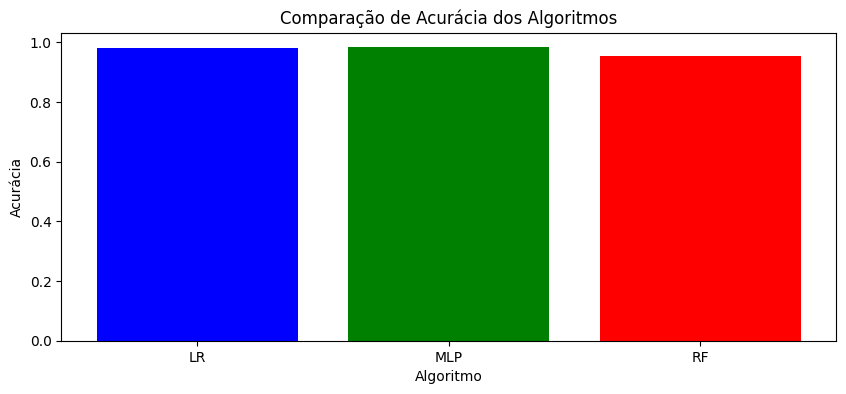

In [ ]:
# Crie um gráfico para comparar a acurácia dos algoritmos
algorithms = ["LR", "MLP", "RF"]
accuracies = [lr_acuracia, mlp_acuracia, rf_acuracia]

plt.figure(figsize=(10, 4))
plt.bar(algorithms, accuracies, color=['blue', 'green', 'red'])
plt.xlabel("Algoritmo")
plt.ylabel("Acurácia")
plt.title("Comparação de Acurácia dos Algoritmos")
plt.show()

In [ ]:
# Printando o erro medio absoluto e o erro medio quadratico
print('MAE e MSE dos principais algoritmos:')
print('\nLR\nMAE: ', mean_absolute_error(y_test, lr_pred), '\nMSE: ', mean_squared_error(y_test, lr_pred))

print('\nMLP\nMAE: ', mean_absolute_error(y_test, mlp_pred), '\nMSE: ', mean_squared_error(y_test, mlp_pred))

print('\nRF\nMAE: ', mean_absolute_error(y_test, rf_pred), '\nMSE: ', mean_squared_error(y_test, rf_pred))

MAE e MSE dos principais algoritmos:

LR
MAE:  15.374762133031103 
MSE:  416.92138500609394

MLP
MAE:  14.764317639735708 
MSE:  397.3773899829142

RF
MAE:  25.296309600000193 
MSE:  1062.287887999936


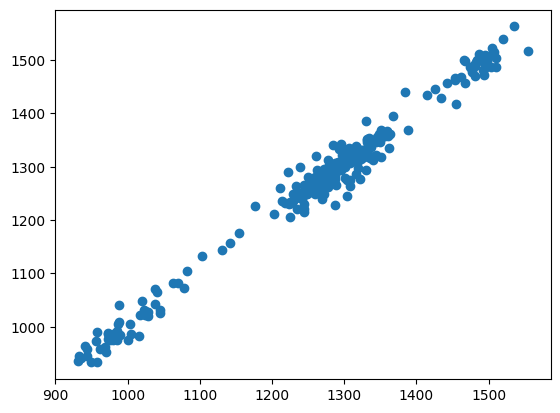

In [ ]:
# Printando o valor de scatter
plt.scatter(y_test, lr_pred)

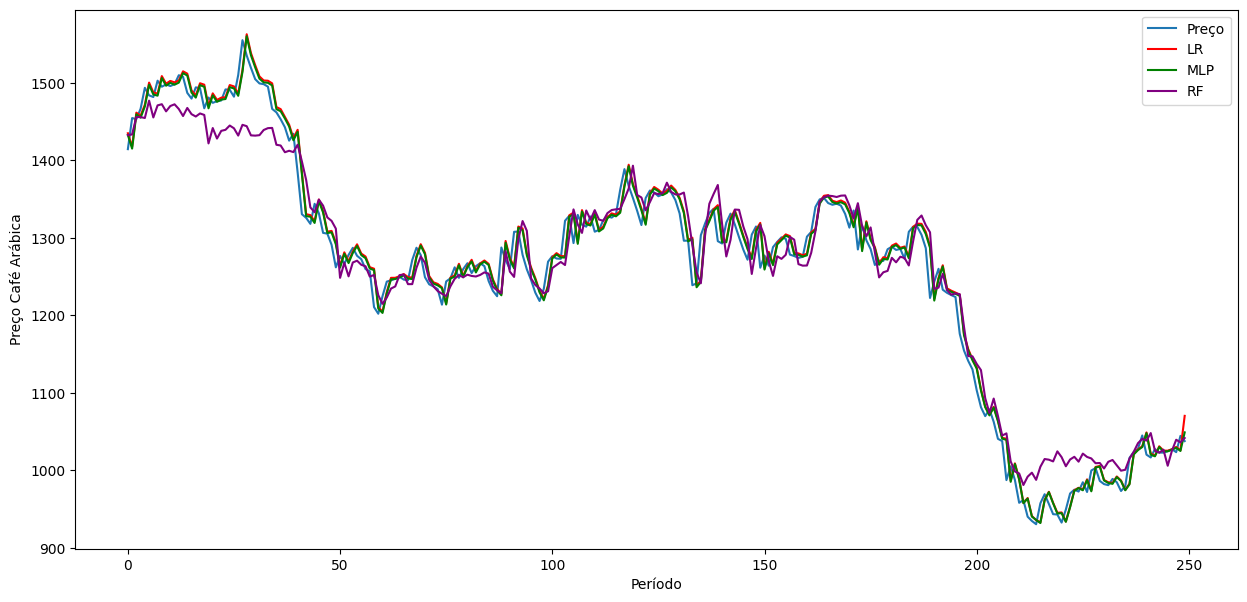

In [ ]:
# Printando o grafico

plt.subplots(figsize=(15, 7))
plt.plot(y_test, label='Preço')
plt.plot(lr_pred, color='red', label='LR')
plt.plot(mlp_pred, color='green', label='MLP')
plt.plot(rf_pred, color='purple', label='RF')
plt.ylabel('Preço Café Arábica')
plt.xlabel('Período')
plt.legend()

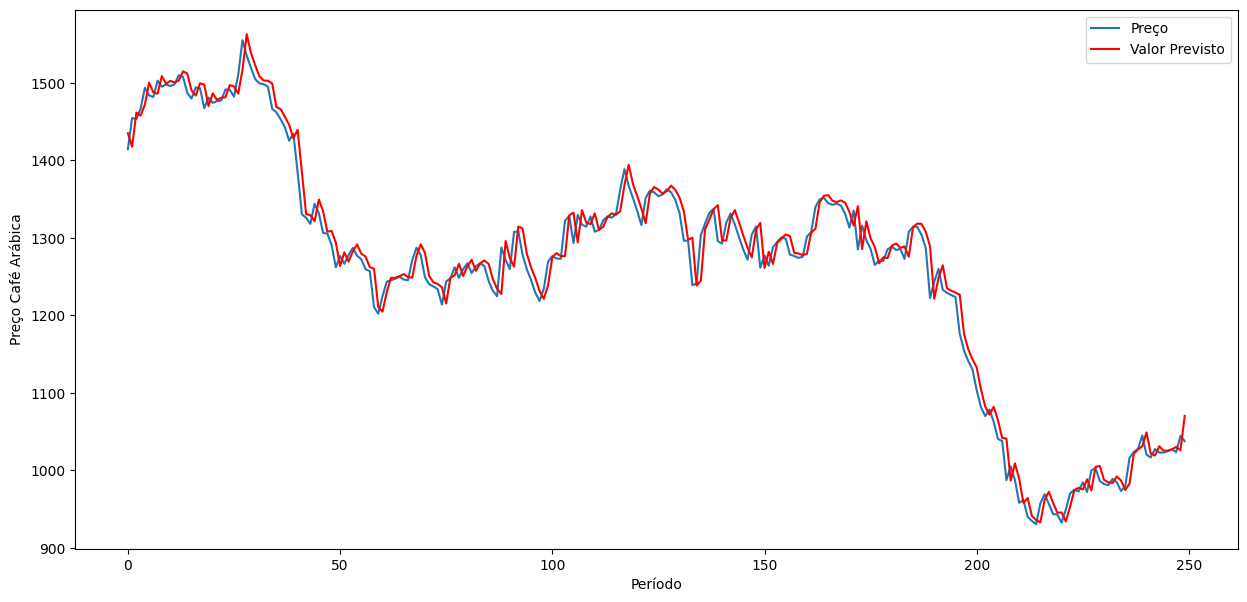

In [ ]:
# Printando o grafico de Regressão Linear

plt.subplots(figsize=(15, 7))
plt.plot(y_test, label='Preço')
plt.plot(lr_pred, color='red', label='Valor Previsto')
plt.ylabel('Preço Café Arábica')
plt.xlabel('Período')
plt.legend()

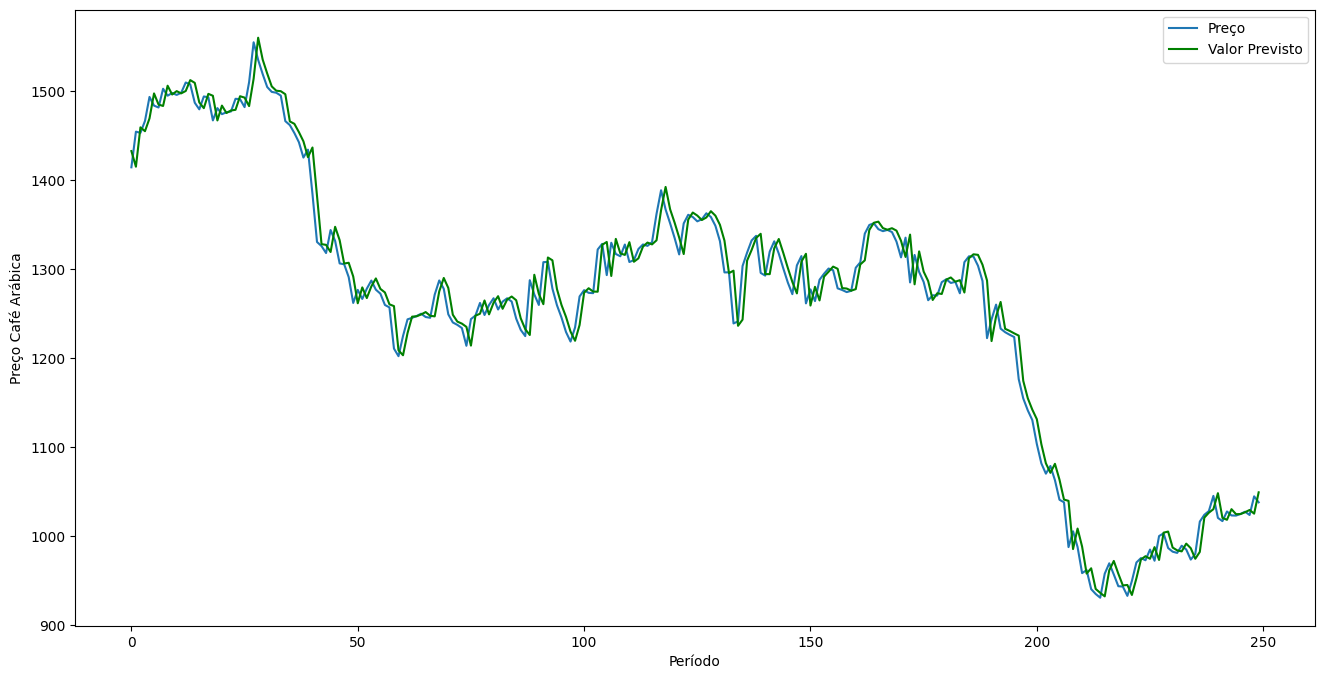

In [ ]:
# Printando o grafico MLP

plt.subplots(figsize=(16, 8))
plt.plot(y_test, label='Preço')
plt.plot(mlp_pred, color='green', label='Valor Previsto')
plt.ylabel('Preço Café Arábica')
plt.xlabel('Período')
plt.legend()

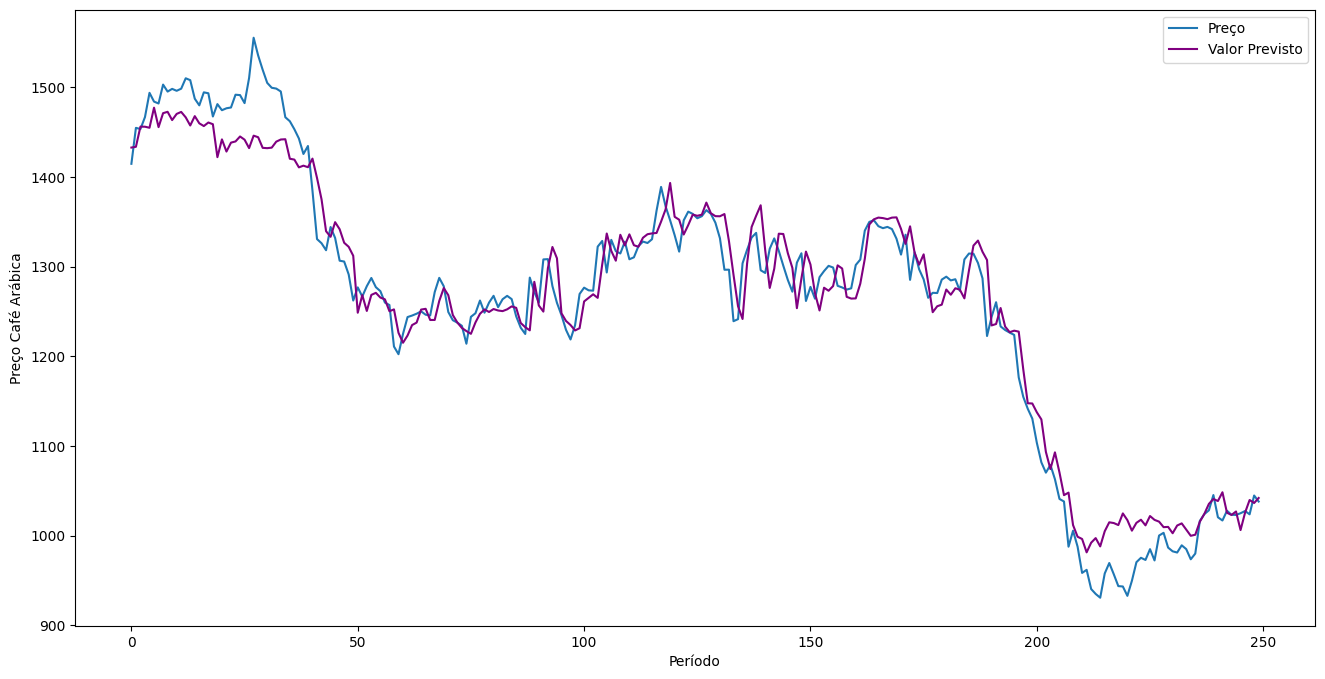

In [ ]:
# Printando o grafico random forest regressor

plt.subplots(figsize=(16, 8))
plt.plot(y_test, label='Preço')
plt.plot(rf_pred, color='purple', label='Valor Previsto')
plt.ylabel('Preço Café Arábica')
plt.xlabel('Período')
plt.legend()

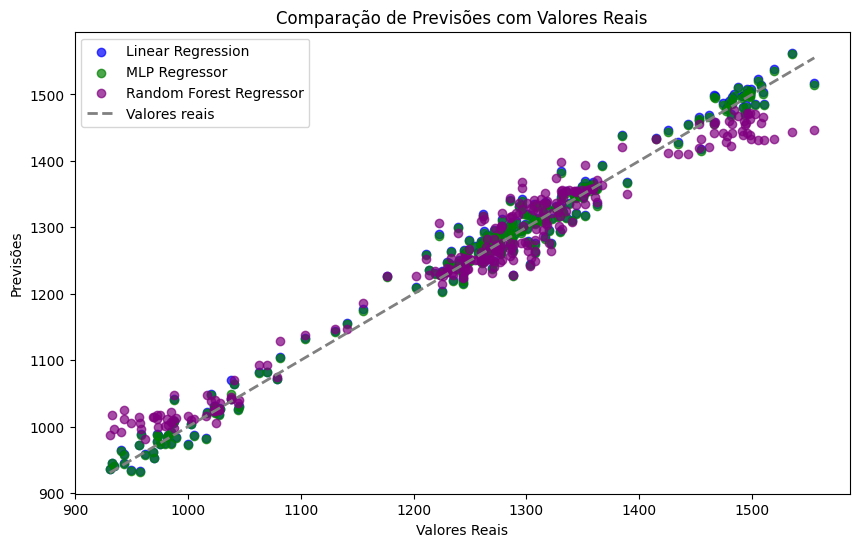

In [ ]:
# Criando um gráfico de dispersão para comparar as previsões dos modelos com os valores reais
plt.figure(figsize=(10, 6))

# Gráfico para Linear Regression
plt.scatter(y_test, lr_pred, color='blue', label='Linear Regression', alpha=0.7)

# Gráfico para MLP Regressor
plt.scatter(y_test, mlp_pred, color='green', label='MLP Regressor', alpha=0.7)

# Gráfico para Random Forest Regressor
plt.scatter(y_test, rf_pred, color='purple', label='Random Forest Regressor', alpha=0.7)

# Linha diagonal para indicar onde as previsões ideais estariam
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', linewidth=2, label='Valores reais')

plt.title('Comparação de Previsões com Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()
plt.show()


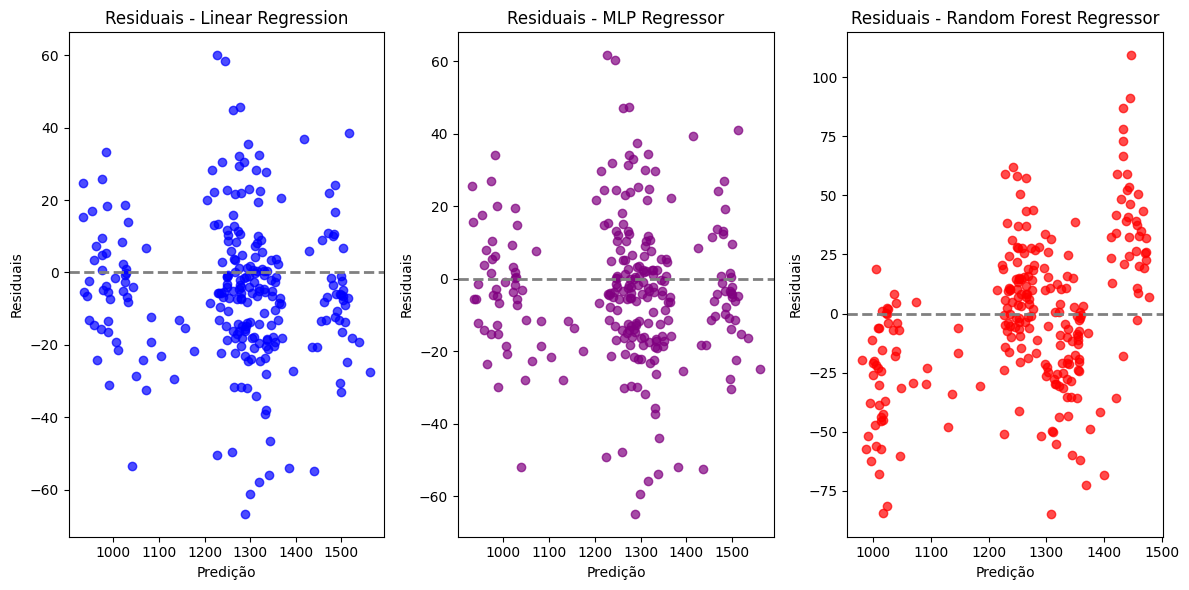

In [ ]:
# Calculando os resíduos para cada modelo
lr_residuals = y_test - lr_pred
mlp_residuals = y_test - mlp_pred
rf_residuals = y_test - rf_pred

# Criando um gráfico residual
plt.figure(figsize=(12, 6))

# Gráfico para Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(lr_pred, lr_residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)
plt.title('Residuais - Linear Regression')
plt.xlabel('Predição')
plt.ylabel('Residuais')

# Gráfico para MLP Regressor
plt.subplot(1, 3, 2)
plt.scatter(mlp_pred, mlp_residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)
plt.title('Residuais - MLP Regressor')
plt.xlabel('Predição')
plt.ylabel('Residuais')

# Gráfico para Random Forest Regressor
plt.subplot(1, 3, 3)
plt.scatter(rf_pred, rf_residuals, color='red', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)
plt.title('Residuais - Random Forest Regressor')
plt.xlabel('Predição')
plt.ylabel('Residuais')

plt.tight_layout()
plt.show()


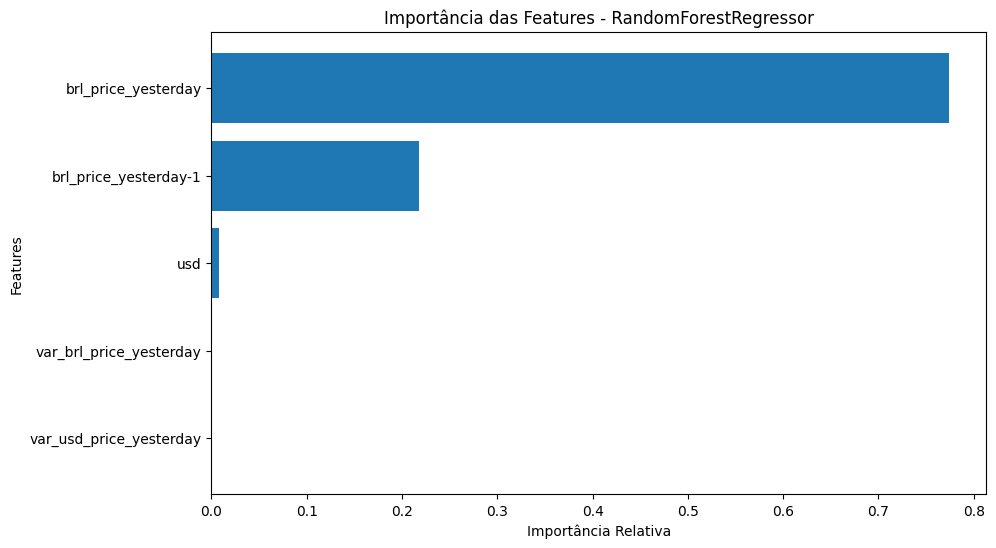

In [ ]:
# Treinando o modelo RandomForestRegressor (se ainda não estiver treinado)
rf_reg = RandomForestRegressor(random_state=1).fit(X_train, y_train)

# Obtendo a importância das features
feature_importances = rf_reg.feature_importances_

# Obtendo o nome das features
feature_names = df.drop(['brl_price'], axis=1).columns

# Ordenando as features pela importância
sorted_idx = np.argsort(feature_importances)

# Criando o gráfico de barras das features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel('Importância Relativa')
plt.ylabel('Features')
plt.title('Importância das Features - RandomForestRegressor')
plt.show()


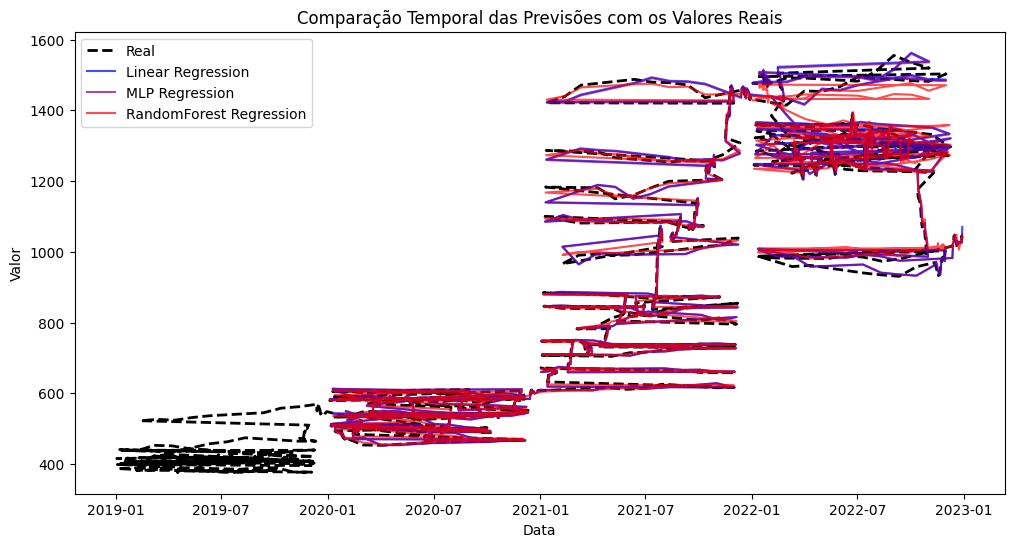

In [ ]:
# Criando um DataFrame para armazenar os resultados
results = pd.DataFrame(index=df.index)

# Adicionando colunas para os valores reais e as previsões de cada modelo
results['Real'] = df['brl_price']
results['Linear Regression'] = np.nan
results['MLP Regression'] = np.nan
results['RandomForest Regression'] = np.nan

# Populando as colunas com as previsões
for idx, yr in enumerate(year_list[:-1]):
    test_idx = results.index.year.isin([year_list[idx + 1]])
    X_test_temp = splits['test'][idx].drop(['brl_price'], axis=1).values
    results.loc[test_idx, 'Linear Regression'] = lr_reg.predict(X_test_temp)
    results.loc[test_idx, 'MLP Regression'] = mlp_reg.predict(X_test_temp)
    results.loc[test_idx, 'RandomForest Regression'] = rf_reg.predict(X_test_temp)

# Plotando o gráfico de comparação temporal
plt.figure(figsize=(12, 6))
plt.plot(results['Real'], label='Real', color='black', linestyle='--', linewidth=2)
plt.plot(results['Linear Regression'], label='Linear Regression', color='blue', alpha=0.7)
plt.plot(results['MLP Regression'], label='MLP Regression', color='purple', alpha=0.7)
plt.plot(results['RandomForest Regression'], label='RandomForest Regression', color='red', alpha=0.7)

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação Temporal das Previsões com os Valores Reais')
plt.legend()
plt.show()
